In [8]:
#dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

In [9]:
#load assesment file
CSCO = "resources/HistoricalData_CSCO.csv"
CSCO_df = pd.read_csv(CSCO)
CSCO_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,05/24/2021,$53.39,21128860,$52.96,$53.765,$52.79
1,05/21/2021,$52.43,24468370,$52.765,$52.93,$52.24
2,05/20/2021,$52.85,48830760,$50.41,$52.97,$50.1
3,05/19/2021,$52.47,29187940,$51.88,$52.66,$51.86
4,05/18/2021,$52.93,20177200,$52.8,$53.34,$52.74


CLEAN, RESHAPE AND CONVERT DATATYPE

In [10]:
CSCO_df['Date']= pd.to_datetime(CSCO_df['Date'])
CSCO_df['Close/Last'] = CSCO_df['Close/Last'].str.replace('$','')
CSCO_df['Open'] = CSCO_df['Open'].str.replace('$','')
CSCO_df['High'] = CSCO_df['High'].str.replace('$','')
CSCO_df['Low'] = CSCO_df['Low'].str.replace('$','')
CSCO_df = CSCO_df.apply( pd.to_numeric)

<ipython-input-10-8171b38c4446>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  CSCO_df['Close/Last'] = CSCO_df['Close/Last'].str.replace('$','')
<ipython-input-10-8171b38c4446>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  CSCO_df['Open'] = CSCO_df['Open'].str.replace('$','')
<ipython-input-10-8171b38c4446>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  CSCO_df['High'] = CSCO_df['High'].str.replace('$','')
<ipython-input-10-8171b38c4446>:5: FutureWarning: The default value of regex will change from True to False in a

FORMAT DATE COLUMN

In [11]:
CSCO_df['Date']= pd.to_datetime(CSCO_df['Date'])
CSCO_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,2021-05-24,53.39,21128860,52.960,53.765,52.79
1,2021-05-21,52.43,24468370,52.765,52.930,52.24
2,2021-05-20,52.85,48830760,50.410,52.970,50.10
3,2021-05-19,52.47,29187940,51.880,52.660,51.86
4,2021-05-18,52.93,20177200,52.800,53.340,52.74


In [12]:
CSCO_df['Open_Close'] = (CSCO_df['Open'] - CSCO_df['Close/Last'])/CSCO_df['Open']
CSCO_df['High_Low'] = (CSCO_df['High'] - CSCO_df['Low'])/CSCO_df['Low']
CSCO_df['Increase_Decrease'] = np.where(CSCO_df['Volume'].shift(-1) > CSCO_df['Volume'],1,0)
CSCO_df['Buy_Sell_on_Open'] = np.where(CSCO_df['Open'].shift(-1) > CSCO_df['Open'],1,0)
CSCO_df['Buy_Sell'] = np.where(CSCO_df['Close/Last'].shift(-1) > CSCO_df['Close/Last'],1,0)
CSCO_df['Returns'] = CSCO_df['Close/Last'].pct_change()
CSCO_df = CSCO_df.dropna()
CSCO_df.head()

,Date,Close/Last,Volume,Open,High,Low,Open_Close,High_Low,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Returns
1,2021-05-21,52.43,24468370,52.765,52.93,52.24,0.006349,0.013208,1,0,1,-0.017981
2,2021-05-20,52.85,48830760,50.410,52.97,50.10,-0.048403,0.057285,0,1,0,0.008011
3,2021-05-19,52.47,29187940,51.880,52.66,51.86,-0.011372,0.015426,0,1,1,-0.007190
4,2021-05-18,52.93,20177200,52.800,53.34,52.74,-0.002462,0.011377,0,0,1,0.008767
5,2021-05-17,52.94,15728680,52.760,53.15,52.68,-0.003412,0.008922,0,1,0,0.000189


SPLIT DATAFRAME

In [13]:
#setup datetime for first 4 years
start_date = "2016-05-24"
end_date = "2020-05-24"

after_start_date = CSCO_df["Date"] >= start_date
before_end_date = CSCO_df["Date"] <= end_date
between_two_dates = after_start_date & before_end_date
CSCO_df_4 = CSCO_df.loc[between_two_dates]
CSCO_df_4.head()

,Date,Close/Last,Volume,Open,High,Low,Open_Close,High_Low,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Returns
252,2020-05-22,44.900,12592810,44.67,44.950,44.1200,-0.005149,0.018812,1,1,0,0.001338
253,2020-05-21,44.640,18674890,45.45,45.655,44.5550,0.017822,0.024689,1,0,1,-0.005791
254,2020-05-20,45.440,20184460,45.05,45.820,45.0300,-0.008657,0.017544,1,0,0,0.017921
255,2020-05-19,44.605,24345420,44.83,44.980,44.4100,0.005019,0.012835,1,1,1,-0.018376
256,2020-05-18,45.060,26980080,45.21,45.295,44.3301,0.003318,0.021766,1,0,0,0.010201


SPLIT DATAFRAME

In [14]:
#setup datetime for last year
start_date = "2020-05-25"
end_date = "2021-05-24"

after_start_date = CSCO_df["Date"] >= start_date
before_end_date = CSCO_df["Date"] <= end_date
between_two_dates = after_start_date & before_end_date
CSCO_df_ls = CSCO_df.loc[between_two_dates]
CSCO_df_ls.head()

,Date,Close/Last,Volume,Open,High,Low,Open_Close,High_Low,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Returns
1,2021-05-21,52.43,24468370,52.765,52.93,52.24,0.006349,0.013208,1,0,1,-0.017981
2,2021-05-20,52.85,48830760,50.410,52.97,50.10,-0.048403,0.057285,0,1,0,0.008011
3,2021-05-19,52.47,29187940,51.880,52.66,51.86,-0.011372,0.015426,0,1,1,-0.007190
4,2021-05-18,52.93,20177200,52.800,53.34,52.74,-0.002462,0.011377,0,0,1,0.008767
5,2021-05-17,52.94,15728680,52.760,53.15,52.68,-0.003412,0.008922,0,1,0,0.000189


PLOT FIRST DF (4YEARS)

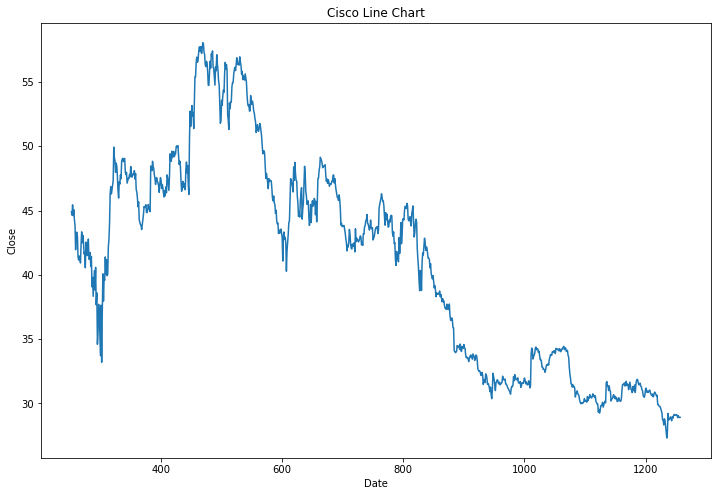

In [15]:
plt.figure(figsize=(12,8))
plt.plot(CSCO_df_4['Close/Last'])
plt.title("Cisco Line Chart")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

PLOT SECOND DF (LAST YEAR)

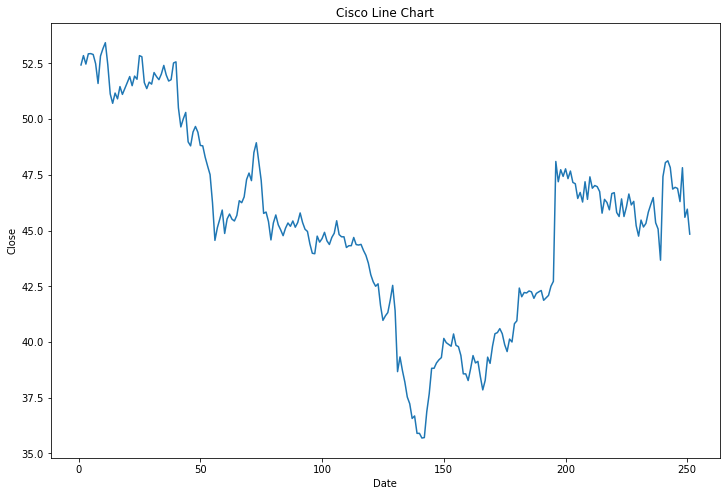

In [16]:
plt.figure(figsize=(12,8))
plt.plot(CSCO_df_ls['Close/Last'])
plt.title("Cisco Line Chart")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

SHAPPING, FITTING, TRAINING, TESTING ML ON 1ST DF

In [17]:
CSCO_df_4.shape

(1006, 12)

In [18]:
X = np.array(CSCO_df_4['Open']).reshape(1006,-1)
Y = np.array(CSCO_df_4['Close/Last']).reshape(1006,-1)

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
lr = LinearRegression()

In [21]:
lr.fit(X, Y)

LinearRegression()

In [22]:
print('Linear Regression intercept:', lr.intercept_)
print('coefficient count:', len(lr.coef_))

Linear Regression intercept: [0.18821674]
coefficient count: 1


In [23]:
from sklearn.metrics import accuracy_score
print('Accuracy:', lr.score(X, Y))

Accuracy: 0.9959163112941813


In [24]:
# Predicting the price
lr.predict(X)

array([[44.65815329],
       [45.43465991],
       [45.03645139],
       ...,
       [29.00855843],
       [28.91896151],
       [28.64021555]])

In [25]:
#daily Return
DA_RE = CSCO_df_4['Close/Last'].pct_change(1)
DA_RE.head()

252         NaN
253   -0.005791
254    0.017921
255   -0.018376
256    0.010201
Name: Close/Last, dtype: float64

Text(0.5, 1.0, '4 Years CLosing Price vs Predicted Closing Price')

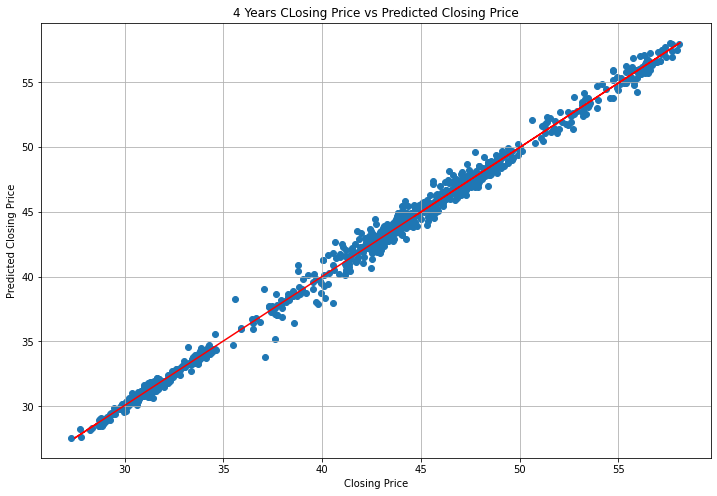

In [31]:
plt.figure(figsize=(12,8))
plt.scatter(CSCO_df_4['Close/Last'], lr.predict(X))
plt.plot(X, lr.predict(X), color = 'red')
plt.xlabel('Closing Price')
plt.ylabel('Predicted Closing Price')
plt.savefig('images/CSCO_4y.jpg', dpi=40)
plt.grid()
plt.title('4 Years CLosing Price vs Predicted Closing Price')

TRAINING, TESTING ML ON 2ND DF

In [32]:
CSCO_df_ls.shape

(251, 12)

In [34]:
X_ls = np.array(CSCO_df_ls['Open']).reshape(251,-1)
Y_ls = np.array(CSCO_df_ls['Close/Last']).reshape(251,-1)

In [35]:
lr.fit(X_ls, Y_ls)

LinearRegression()

In [36]:
print('Linear Regression intercept:', lr.intercept_)
print('coefficient count:', len(lr.coef_))

Linear Regression intercept: [-0.291846]
coefficient count: 1


In [37]:
print('Accuracy:', lr.score(X_ls, Y_ls))

Accuracy: 0.9828976853820317


In [38]:
# Predicting the price
lr.predict(X_ls)

array([[52.88161495],
       [50.50838458],
       [51.98976404],
       [52.91688589],
       [52.87657624],
       [53.04789223],
       [52.2215445 ],
       [52.29208638],
       [53.21920823],
       [54.09594301],
       [52.59440872],
       [51.17349373],
       [51.09287443],
       [51.21380337],
       [51.31457748],
       [51.3246549 ],
       [51.28434525],
       [51.66728688],
       [51.6874417 ],
       [51.75798358],
       [51.61034951],
       [51.91922216],
       [51.9494544 ],
       [52.70526025],
       [52.63975708],
       [52.56417649],
       [51.86883511],
       [51.61689982],
       [51.74790617],
       [52.18123486],
       [51.93937699],
       [52.05022851],
       [52.12077039],
       [52.09053816],
       [51.73581328],
       [51.8587577 ],
       [51.93937699],
       [52.2215445 ],
       [52.51459563],
       [50.69985539],
       [50.67466186],
       [50.03474624],
       [50.11536553],
       [49.02700511],
       [48.79522465],
       [48

Text(0.5, 1.0, '1 Year CLosing Price vs Predicted Closing Price')

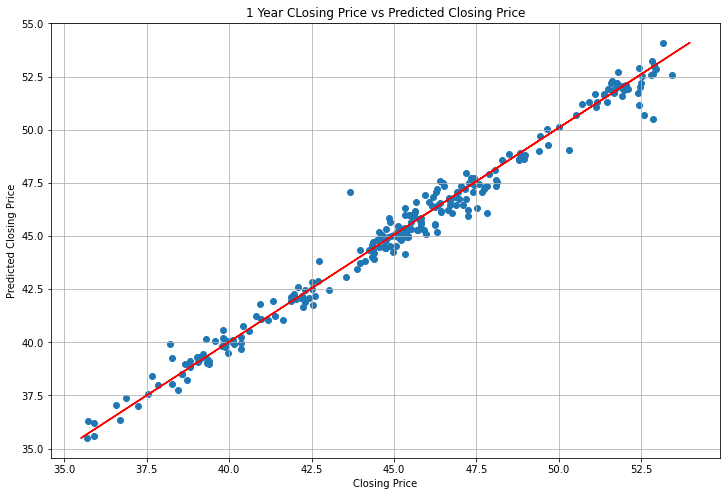

In [39]:
plt.figure(figsize=(12,8))
plt.scatter(CSCO_df_ls['Close/Last'], lr.predict(X_ls))
plt.plot(X_ls, lr.predict(X_ls), color = 'red')
plt.xlabel('Closing Price')
plt.ylabel('Predicted Closing Price')
plt.savefig('images/CSCO_ls.jpg', dpi=40)
plt.grid()
plt.title('1 Year CLosing Price vs Predicted Closing Price')